# Majuro Atoll (Republic of the Marshall Islands)

In [1]:
# os
import os
import os.path as op
import sys

# arrays
import math
import numpy as np
import pandas as pd
from scipy import signal as sg

# plot
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies
if(os.path.isdir('waves-main')): #thebe
    os.chdir('waves-main')
from lib.eta_spec import *

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# path to data
if(os.path.isdir('data')):
    p_data = op.abspath(op.join(os.getcwd(), 'data', 'Majuro')) # thebe
else:
    p_data = op.abspath(op.join(os.getcwd(),'..', '..', '..', 'data', 'Majuro')) # notebook
    
p_pressure = op.join(p_data, 'Pressure')

For this study, 1-second data were collected from four pressure sensors deployed during the winter season of 2016-2017 (from mid-November until early February) by Murray Ford (University of Auckland). These pressure sensors were located in the lagoon as shown in the figure bellow; sensors 41320 (tidal gauge) and 41323 were placed closely at the east-side lagoon shoreline, 41321 is situated in the middle of the lagoon and 41322 in front of the shipping channel

#### Majuro lagoon and pressure sensors location (Ford et al. 2018)

![Majuro_instrumental_data.png](Majuro_instrumental_data.png)


### Load data


In [4]:
# Murray sensors  -->  sea pressure (1-sec data)
#xds_41320p = xr.open_dataset(p_pressure + '/Data_41320_pressure')
xds_41321p = xr.open_dataset(p_pressure + '/Data_41321_pressure')
#xds_41322p = xr.open_dataset(p_pressure + '/Data_41322_pressure')
#xds_41323p = xr.open_dataset(p_pressure + '/Data_41323_pressure')


## A.1 Observations

In [5]:
sensor = xds_41321p

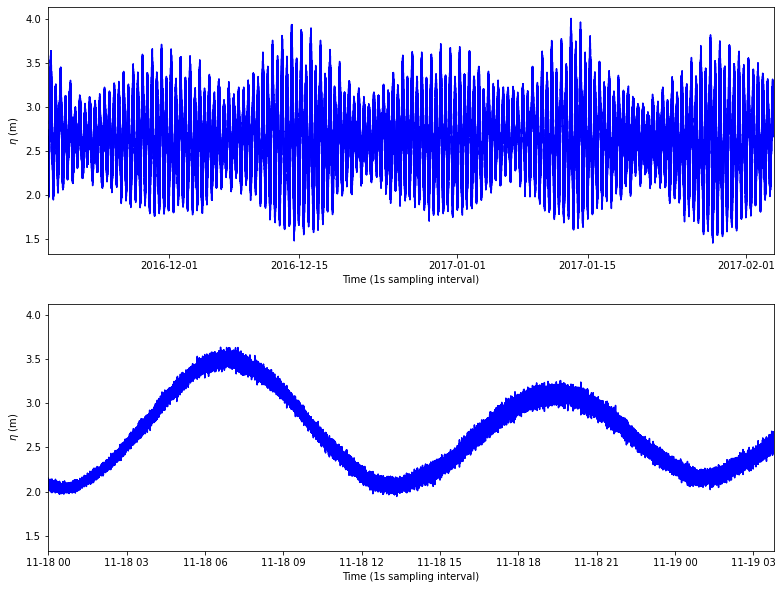

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(13,10))
axs[0].plot(sensor.time, sensor.Depth, color='b')
axs[1].plot(sensor.time, sensor.Depth, color='b')

axs[0].set_xlabel('Time (1s sampling interval)')
axs[0].set_ylabel('$\eta$ (m)')

axs[1].set_xlabel('Time (1s sampling interval)')
axs[1].set_ylabel('$\eta$ (m)')

axs[0].set_xlim([sensor.time.values[0], sensor.time.values[-1]])
axs[1].set_xlim([sensor.time.values[0], sensor.time.values[100000]])
plt.show()

In [7]:
print("Mean:              ", np.mean(sensor.Depth.values))
print("Standar Deviation: ", np.var(sensor.Depth.values))

Mean:               2.6380446707445464
Standar Deviation:  0.185952843311758


## A.2. Spectral Analysis

In [8]:
# Calculate spectra help(sg.welch)
f, E = sg.welch(sensor.Depth, fs = 1, nfft=4*1024)

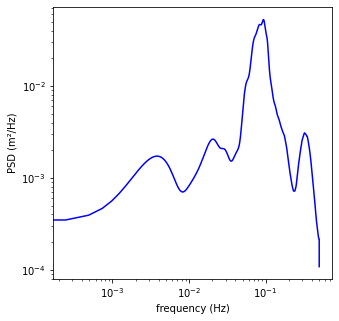

In [9]:
# Plot wave spectrum
plt.figure(figsize=(5,5))
plt.loglog(f, E, c='b')
plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.show()

In [10]:
print('Peak frequency: ' + str(f[np.argmax(E)]))
print('Peak period:    ' + str(1/f[np.argmax(E)]))

Peak frequency: 0.093505859375
Peak period:    10.694516971279374


In [11]:
# Eliminate lowest-frequency spectral energy
Es = E[np.where(f > (1/30))[0]]
fs = f[np.where(f > (1/30))[0]]

Ei = E[np.where((f > (1/(5*60))) & (f < (1/30)))[0]]
fi = f[np.where((f > (1/(5*60))) & (f < (1/30)))[0]]

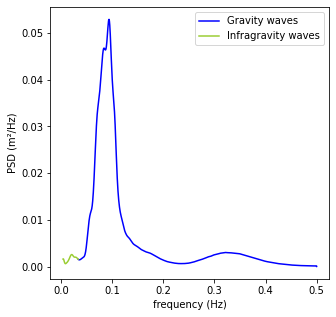

In [12]:
# Plot short-waves spectrum
plt.figure(figsize=(5,5))
plt.plot(fs, Es, c='b', label='Gravity waves', zorder=1)
plt.plot(fi, Ei, c='yellowgreen', label='Infragravity waves', zorder=2)

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

In [13]:
print('Peak frequency: ' + str(fs[np.argmax(Es)]))
print('Peak period:    ' + str(1/fs[np.argmax(Es)]))

Peak frequency: 0.093505859375
Peak period:    10.694516971279374


### JONSWAP Goda (1985)

$S(f)=\alpha\cdot H_{s}^{2} \cdot T_{p}^{-4} \cdot f^{-5} \cdot e^{-1.25 \cdot (T_{p} \cdot f)^{-4}} \cdot \gamma^{e^{-(T_{p} \cdot f - 1)^{2}/(2 \cdot \sigma^{2})}}$ 


$\alpha \approxeq \frac{0.0624}{0.230+0.0336 \cdot \gamma - 0.185 \cdot (1.9 + \gamma)^{-1}}$

$
\sigma=\begin{cases}
\sigma_{a};  f \leq f_{p} \\ \sigma_{b}; f \geq f_{p}
\end{cases}
$

$\gamma = 1 to 7 (mean 3.3), \sigma_{a}\approxeq0.07, \sigma_{b}\approxeq 0.09$

In [14]:
gamma, EJon = assess_jonwsap(fs, Es)
print('Best gamma JONSWAP fit: ' + str(gamma))

Best gamma JONSWAP fit: 3


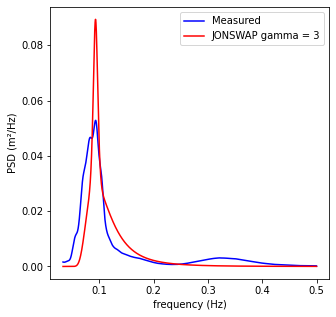

In [15]:
# Plot measured wave spectrum and theorecial JONSWAP shapes
plt.figure(figsize=(5,5))
plt.plot(fs, Es, c='b', label='Measured')
plt.plot(fs[:-1], EJon, c='r', label='JONSWAP gamma = {0}'.format(gamma))

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

## A.3 Short-term statistics

In [16]:
# Select 1 moth
start = '2017-01-14T05:00:00.000000000'
end = '2017-01-14T06:00:00.000000000'
sensor_i = sensor.sel(time=slice(start, end))

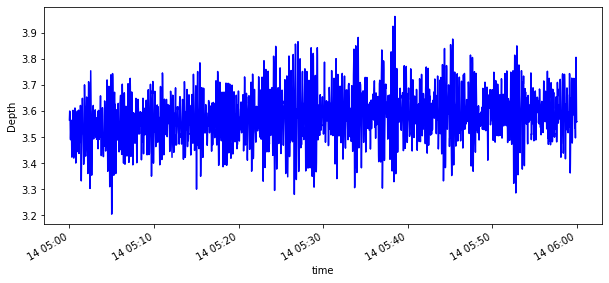

In [17]:
sensor_i.Depth.plot(figsize=(10,4), c='b')
plt.show()

In [18]:
samp = 1
T, H = upcrossing(sensor_i.Depth.values, samp)

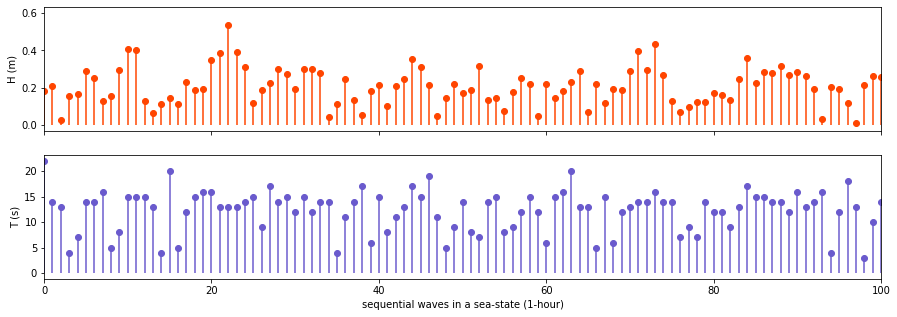

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
axs[0].vlines(range(len(H)), np.full(len(H), 0), H, color='orangered')
axs[1].vlines(range(len(T)), np.full(len(T), 0), T, color='slateblue')
axs[0].scatter(range(len(H)), H, color='orangered')
axs[1].scatter(range(len(T)), T, color='slateblue')

axs[0].set_ylabel('H (m)')
axs[1].set_ylabel('T (s)')
axs[1].set_xlabel('sequential waves in a sea-state (1-hour)')

plt.xlim(0, 100)
plt.show()

### Statistical parameters

`mean wave heigh` $\overline H$

$\overline H = \frac{1}{N} \sum_{i=1}^{N} H_{i}$ <br> where i is the sequence number (in time) of the wave in the record

`root-mean-square wave height` $H_{rms}$

$H_{rms}=(\frac{1}{N} \sum_{i=1}^{N} H_{i}^{2})^{1/2}$

`significant wave heigh` $H_{1/3}$

$H_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} H_{j}$ <br> where j is the rank number of the wave, based on wave-heigh

`mean of the highest one-tenth of waves` $H_{1/10}$

$H_{1/10}=\frac{1}{N/10} \sum_{j=1}^{N/10} H_{j}$ 

`mean zero-crossing wave period` $\overline T_{0}$

$\overline T_{0}=\frac{1}{N} \sum_{i=1}^{N} T_{0,i}$

`significant wave period` $T_{1/3}$

$T_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} T_{0,j}$

In [20]:
# mean wave heigh
print("mean wave heigh:                        " + str(np.mean(H)))

# root-mean-square wave height
print("root-mean-square wave height:           " + str(rmsV(H)))

# significant wave heigh
print("significant wave heigh:                 " + str(highestN_stats(H, 3)))

# mean of the highest one-tenth of waves
print("mean of the highest one-tenth of waves: " + str(highestN_stats(H, 10)))

# maximun wave heigh
print("maximun wave heigh:                     " + str(np.max(H)))

# mean period
print("mean period:                            " + str(np.mean(T)))

# significant wave period
print("significant wave period:                " + str(highestN_stats(T, 3)))

# mean zero-crossing wave period
print("mean zero-crossing wave period:         " + str(highestN_stats(T, 10)))

# maximun wave period
print("maximun wave period:                    " + str(np.max(T)))

mean wave heigh:                        0.22453318954172838
root-mean-square wave height:           0.2569251425726257
significant wave heigh:                 0.36802250309390466
mean of the highest one-tenth of waves: 0.4832906223671765
maximun wave heigh:                     0.6027064883586348
mean period:                            11.93645484949833
significant wave period:                15.949494949494992
mean zero-crossing wave period:         17.79310344827595
maximun wave period:                    22.000000000000007


## Wave Heigh Distribution

In [21]:
# Rayleigh distribution of individual wave heighs
fHs = [4.01 * (i/(4 * math.sqrt(moment(0, fs, Es)))**2) * np.exp(-2.005 * (i**2/(4 * np.sqrt(moment(0, fs, Es)))**2)) for i in H]
FHs = [1 - np.exp(-2.005 * (i**2/(4 * np.sqrt(moment(0, fs, Es)))**2)) for i in H]

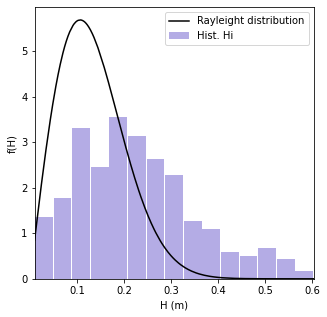

In [22]:
# Plot - sort arrays
plt.figure(figsize=(5,5))
plt.hist(H, density = True, bins = 15, rwidth=0.95, color = "slateblue", alpha=0.5, label='Hist. Hi')
plt.plot(np.sort(H), np.array(fHs)[np.array(H).argsort()], c = "k", zorder = 10, label='Rayleight distribution')

plt.xlabel('H (m)')
plt.ylabel('f(H)')
plt.legend()
plt.xlim(np.nanmin(H), np.nanmax(H))
plt.show()